## 多信号策略逻辑：

1. CCI指标（30分钟信号）
2. RSI指标（30分钟信号）
3. MA指标（60分钟）
4. 固定比率吊灯止损（分钟）

In [1]:
from __future__ import division

from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator,
                                                     ArrayManager)
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiSignalStrategy(CtaTemplate):
    className = 'MultiSignalStrategy'
    author = 'ChannelCMT'
    
    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典
    
    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位
    

    amWindow = 20
    initDays = 1
    # 策略参数
    smaPeriod = 18
    lmaPeriod = 23
    cciPeriod = 12
    rsiPeriod = 4
    rsiEntry = 12
    trailingPercent = 7
    threshold = 2


    
    
    # 策略变量
    transactionPrice = EMPTY_FLOAT # 记录成交价格
    fixedSize = 1 
    longStop = EMPTY_FLOAT
    shortStop = EMPTY_FLOAT
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                 'amWindow',
                 'rsiPeriod',
                 'cciPeriod',
                 'rsiEntry',
                 'smaPeriod',
                 'lmaPeriod',
                 'threshold',
                 'trailingPercent']  
    
    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'transactionPrice',
               'fixedSize',
               'longStop',
               'shortStop']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super(MultiSignalStrategy, self).__init__(ctaEngine, setting)
        
        # 给多空仓位命名
        symbol = self.symbolList[0]
        self.Longpos = symbol.replace('.','_')+"_LONG"
        self.Shortpos = symbol.replace('.','_')+"_SHORT"
        
        self.bg30 = BarGenerator(self.onBar, 30, self.on30MinBar)
        self.bg30Dict = {
            sym: self.bg30
            for sym in self.symbolList
        }
        
        self.am30Dict = {
            sym: ArrayManager(size=self.amWindow*2)
            for sym in self.symbolList
        }
        
        self.bg60 = BarGenerator(self.onBar, 60, self.on60MinBar)
        self.bg60Dict = {
            sym: self.bg60
            for sym in self.symbolList
        }
        
        self.am60Dict = {
            sym: ArrayManager(size=self.amWindow*2)
            for sym in self.symbolList
        }
        
        self.intraTradeHighDict = {}
        self.intraTradeLowDict = {}
        self.RSI = 0
        self.CCI = 0
        self.MA = 0
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        # 初始化仓位字典
        self.ctaEngine.initPosition(self)
        # 初始化历史数据天数
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        bg30 = self.bg30Dict[symbol]
        bg30.updateBar(bar)
        
        bg60 = self.bg60Dict[symbol]
        bg60.updateBar(bar)
        
        # 洗价器
        if self.posDict[self.Longpos] == 0 and self.posDict[self.Shortpos] == 0:
            self.intraTradeHighDict[symbol] = 0
            self.intraTradeLowDict[symbol] = 999999

        # 持有多头仓位
        elif self.posDict[self.Longpos] >0:
            self.intraTradeHighDict[symbol] = max(self.intraTradeHighDict[symbol], bar.high)
            self.intraTradeLowDict[symbol] = bar.low
            self.longStop = self.intraTradeHighDict[symbol]*(1-self.trailingPercent/100)
            if bar.close<=self.longStop:
                self.cancelAll()
                self.sell(symbol, bar.close*0.9, self.posDict[self.Longpos])

#         # 持有空头仓位
        elif self.posDict[self.Shortpos] >0:
            self.intraTradeLowDict[symbol] = min(self.intraTradeLowDict[symbol], bar.low)
            self.intraTradeHighDict[symbol] = bar.high
            self.shortStop = self.intraTradeLowDict[symbol]*(1+self.trailingPercent/100)
            if bar.close>=self.shortStop:
                self.cancelAll()
                self.cover(symbol, bar.close*1.1, self.posDict[self.Shortpos])
        self.putEvent()

    def on30MinBar(self, bar):
        symbol = bar.vtSymbol
        
        am30 = self.am30Dict[symbol]
        am30.updateBar(bar)
        if not am30.inited:
            return
        
        cci = ta.CCI(am30.high, am30.low, am30.close, self.cciPeriod)
        rsi = ta.RSI(am30.close, self.rsiPeriod)
        rsiLong = 50 + self.rsiEntry
        rsiShort = 50 - self.rsiEntry
        
        if cci[-1]>10:
            self.CCI = 1
        elif cci[-1]<-10:
            self.CCI = -1
        else:
            self.CCI = 0
        
        if rsi[-1]>=rsiLong:
            self.RSI = 1
        elif rsi[-1]<=rsiShort:
            self.RSI = -1
        else:
            self.RSI = 0
        
        # 发出状态更新事件
        self.putEvent()

    def on60MinBar(self, bar):
        symbol = bar.vtSymbol
        
        am60 = self.am60Dict[symbol]
        am60.updateBar(bar)
        if not am60.inited:
            return
        
        SMA = ta.MA(am60.close, self.smaPeriod)
        LMA = ta.MA(am60.close, self.lmaPeriod)
        
        if SMA[-1]>LMA[-1]:
            self.MA = 1
        elif SMA[-1]<LMA[-1]:
            self.MA = -1
        else:
            self.MA = 0
        
        Signal = self.MA+self.CCI+self.RSI

        if Signal>=2:
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.buy(symbol,bar.close*1.1, self.fixedSize)
            elif self.posDict[self.Shortpos] > 0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.1, self.posDict[self.Shortpos])
                self.buy(symbol,bar.close*1.1, self.fixedSize)
            
        elif Signal<=-2:
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.short(symbol,bar.close*0.9, self.fixedSize)
            elif self.posDict[self.Longpos]>0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.9, self.fixedSize)
                self.short(symbol,bar.close*0.9, self.fixedSize)
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        self.transactionPrice = trade.price
#         print(self.posDict)
        pass

    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [2]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME

# 创建回测引擎对象
engine = BacktestingEngine()
# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
engine.setStartDate('20180101',initDays=5)               # 设置回测用的数据起始日期
engine.setEndDate('20180630')
# 配置回测引擎参数
engine.setSlippage(0.2)     # 设置滑点为0.2跳
engine.setRate(1/1000)   # 设置手续费千1
engine.setSize(1)         # 设置合约大小 
engine.setPriceTick(0.1)    # 设置股指最小价格变动   
engine.setCapital(1000000)  # 设置回测本金
# 在引擎中创建策略对象
d = {'symbolList':['tBTCUSD:bitfinex']}                    # 策略参数配置
engine.initStrategy(MultiSignalStrategy, d)    # 创建策略对象
engine.runBacktesting()

2018-07-14 14:54:01.734286	开始回测
2018-07-14 14:54:01.734286	策略初始化
2018-07-14 14:54:01.734286	载入历史数据。数据范围:[20171227,20180101)
2018-07-14 14:54:02.384622	载入完成，数据量：7173
2018-07-14 14:54:02.430575	策略初始化完成
2018-07-14 14:54:02.431574	策略启动完成
2018-07-14 14:54:02.431574	开始回放回测数据,回测范围:[20180101,20180701)
2018-07-14 14:54:02.431574	载入历史数据。数据范围:[20180101,20180311)
2018-07-14 14:54:11.023802	载入完成，数据量：99357
2018-07-14 14:54:11.023802	当前回放数据:[20180101,20180311)
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0,

{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitf

{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitf

{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 1}
{'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
{'tBTCUSD:bitfinex_LONG': 1, 'tBTCUSD:bitfinex_SHORT': 0}
2018-07-14 14:54:27.883968	数据回放结束ss: 100%    


In [3]:
# 显示前10条成交记录
for i in range(10000):
    d = engine.tradeDict[str(i+1)].__dict__
    print('TradeID: %s, Time: %s, Direction: %s, Price: %s, Volume: %s' %(d['tradeID'], d['dt'], d['direction'], d['price'], d['volume']))

TradeID: 1, Time: 2018-01-01 00:01:00, Direction: 多, Price: 13330.0, Volume: 1
TradeID: 2, Time: 2018-01-01 19:11:00, Direction: 空, Price: 13187.0, Volume: 1
TradeID: 3, Time: 2018-01-01 21:01:00, Direction: 空, Price: 13155.0, Volume: 1
TradeID: 4, Time: 2018-01-02 08:30:00, Direction: 多, Price: 13757.0, Volume: 1
TradeID: 5, Time: 2018-01-02 11:01:00, Direction: 空, Price: 13514.0, Volume: 1
TradeID: 6, Time: 2018-01-02 17:01:00, Direction: 多, Price: 13409.0, Volume: 1
TradeID: 7, Time: 2018-01-02 17:01:00, Direction: 多, Price: 13409.0, Volume: 1
TradeID: 8, Time: 2018-01-04 12:01:00, Direction: 空, Price: 15029.0, Volume: 1
TradeID: 9, Time: 2018-01-04 12:01:00, Direction: 空, Price: 15029.0, Volume: 1
TradeID: 10, Time: 2018-01-05 04:10:00, Direction: 多, Price: 15049.0, Volume: 1
TradeID: 11, Time: 2018-01-05 11:01:00, Direction: 多, Price: 15065.0, Volume: 1
TradeID: 12, Time: 2018-01-07 22:01:00, Direction: 空, Price: 16417.0, Volume: 1
TradeID: 13, Time: 2018-01-07 22:01:00, Direction

TradeID: 104, Time: 2018-02-06 17:12:00, Direction: 多, Price: 6482.8, Volume: 1
TradeID: 105, Time: 2018-02-07 02:01:00, Direction: 空, Price: 7030.0, Volume: 1
TradeID: 106, Time: 2018-02-07 03:49:00, Direction: 多, Price: 7465.0, Volume: 1
TradeID: 107, Time: 2018-02-07 05:01:00, Direction: 多, Price: 7556.7, Volume: 1
TradeID: 108, Time: 2018-02-07 10:52:00, Direction: 空, Price: 7316.3, Volume: 1
TradeID: 109, Time: 2018-02-07 16:01:00, Direction: 多, Price: 7682.57579419, Volume: 1
TradeID: 110, Time: 2018-02-08 06:30:00, Direction: 空, Price: 7876.1, Volume: 1
TradeID: 111, Time: 2018-02-08 11:01:00, Direction: 多, Price: 8080.2, Volume: 1
TradeID: 112, Time: 2018-02-08 23:01:00, Direction: 空, Price: 8429.0, Volume: 1
TradeID: 113, Time: 2018-02-08 23:01:00, Direction: 空, Price: 8429.0, Volume: 1
TradeID: 114, Time: 2018-02-09 04:01:00, Direction: 多, Price: 8427.1, Volume: 1
TradeID: 115, Time: 2018-02-09 04:01:00, Direction: 多, Price: 8427.1, Volume: 1
TradeID: 116, Time: 2018-02-09 09

TradeID: 211, Time: 2018-03-25 06:01:00, Direction: 空, Price: 8647.0, Volume: 1
TradeID: 212, Time: 2018-03-26 05:01:00, Direction: 多, Price: 8590.9, Volume: 1
TradeID: 213, Time: 2018-03-26 05:01:00, Direction: 多, Price: 8590.9, Volume: 1
TradeID: 214, Time: 2018-03-26 09:01:00, Direction: 空, Price: 8371.0, Volume: 1
TradeID: 215, Time: 2018-03-26 09:01:00, Direction: 空, Price: 8371.0, Volume: 1
TradeID: 216, Time: 2018-03-26 13:01:00, Direction: 多, Price: 8433.9, Volume: 1
TradeID: 217, Time: 2018-03-26 13:01:00, Direction: 多, Price: 8433.9, Volume: 1
TradeID: 218, Time: 2018-03-26 16:01:00, Direction: 空, Price: 8405.2, Volume: 1
TradeID: 219, Time: 2018-03-26 16:01:00, Direction: 空, Price: 8405.2, Volume: 1
TradeID: 220, Time: 2018-03-27 23:01:00, Direction: 多, Price: 8058.6, Volume: 1
TradeID: 221, Time: 2018-03-27 23:01:00, Direction: 多, Price: 8058.6, Volume: 1
TradeID: 222, Time: 2018-03-28 02:01:00, Direction: 空, Price: 7906.5, Volume: 1
TradeID: 223, Time: 2018-03-28 02:01:00,

TradeID: 349, Time: 2018-05-26 01:01:00, Direction: 空, Price: 7442.1, Volume: 1
TradeID: 350, Time: 2018-05-26 14:01:00, Direction: 多, Price: 7433.1, Volume: 1
TradeID: 351, Time: 2018-05-26 14:01:00, Direction: 多, Price: 7433.1, Volume: 1
TradeID: 352, Time: 2018-05-27 11:01:00, Direction: 空, Price: 7297.1, Volume: 1
TradeID: 353, Time: 2018-05-27 11:01:00, Direction: 空, Price: 7297.1, Volume: 1
TradeID: 354, Time: 2018-05-28 06:01:00, Direction: 多, Price: 7329.0, Volume: 1
TradeID: 355, Time: 2018-05-28 06:01:00, Direction: 多, Price: 7329.0, Volume: 1
TradeID: 356, Time: 2018-05-28 16:01:00, Direction: 空, Price: 7205.3, Volume: 1
TradeID: 357, Time: 2018-05-28 16:01:00, Direction: 空, Price: 7205.3, Volume: 1
TradeID: 358, Time: 2018-05-30 00:01:00, Direction: 多, Price: 7422.1, Volume: 1
TradeID: 359, Time: 2018-05-30 00:01:00, Direction: 多, Price: 7422.1, Volume: 1
TradeID: 360, Time: 2018-05-31 00:01:00, Direction: 空, Price: 7327.5, Volume: 1
TradeID: 361, Time: 2018-05-31 00:01:00,

KeyError: '422'

## 策略编写与参数设置

## 查看绩效回测绩效

2018-07-14 14:54:55.089638	计算按日统计结果
2018-07-14 14:54:55.112614	------------------------------
2018-07-14 14:54:55.112614	首个交易日：	2018-01-01
2018-07-14 14:54:55.112614	最后交易日：	2018-06-30
2018-07-14 14:54:55.113613	总交易日：	181
2018-07-14 14:54:55.113613	盈利交易日	92
2018-07-14 14:54:55.113613	亏损交易日：	89
2018-07-14 14:54:55.113613	起始资金：	1000000
2018-07-14 14:54:55.113613	结束资金：	1,013,222.28
2018-07-14 14:54:55.113613	总收益率：	1.32%
2018-07-14 14:54:55.113613	年化收益：	1.75%
2018-07-14 14:54:55.113613	总盈亏：	13,222.28
2018-07-14 14:54:55.113613	最大回撤: 	-2,169.12
2018-07-14 14:54:55.113613	百分比最大回撤: -0.21%
2018-07-14 14:54:55.113613	总手续费：	3,840.99
2018-07-14 14:54:55.113613	总滑点：	84.2
2018-07-14 14:54:55.113613	总成交金额：	3,840,985.45
2018-07-14 14:54:55.113613	总成交笔数：	421
2018-07-14 14:54:55.113613	日均盈亏：	73.05
2018-07-14 14:54:55.113613	日均手续费：	21.22
2018-07-14 14:54:55.113613	日均滑点：	0.47
2018-07-14 14:54:55.113613	日均成交金额：	21,220.91
2018-07-14 14:54:55.113613	日均成交笔数：	2.33
2018-07-14 14:54:55.113613	日均收益率：	0.01%
2018-0

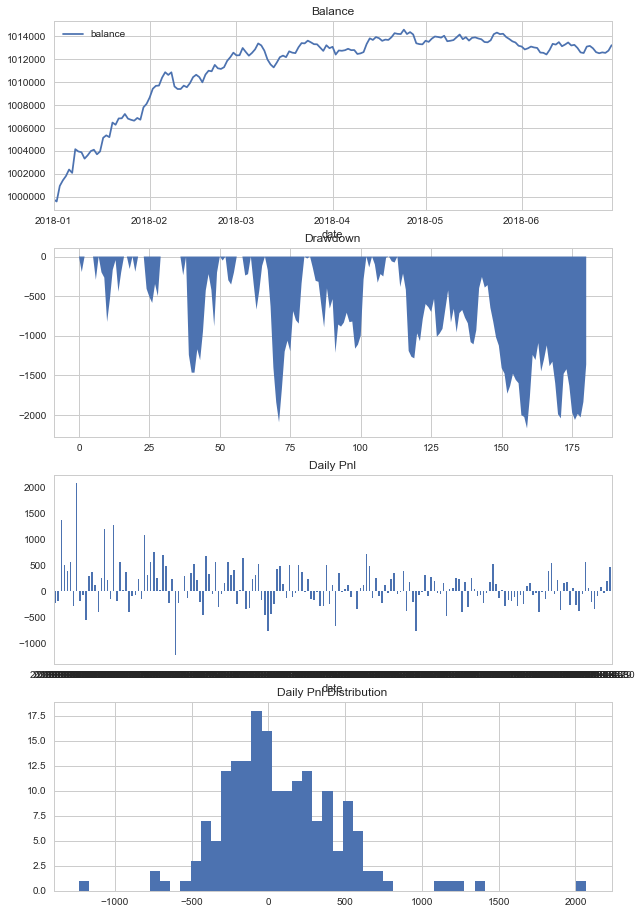

2018-07-14 14:54:56.813877	计算回测结果
2018-07-14 14:54:56.949738	------------------------------
2018-07-14 14:54:56.949738	第一笔交易：	2018-01-01 19:11:00
2018-07-14 14:54:56.949738	最后一笔交易：	2018-06-30 23:59:00
2018-07-14 14:54:56.949738	总交易次数：	211
2018-07-14 14:54:56.949738	总盈亏：	13,215.7
2018-07-14 14:54:56.949738	最大回撤: 	-2,178.11
2018-07-14 14:54:56.949738	平均每笔盈利：	62.63
2018-07-14 14:54:56.949738	平均每笔滑点：	0.4
2018-07-14 14:54:56.949738	平均每笔佣金：	18.23
2018-07-14 14:54:56.949738	胜率		40.28%
2018-07-14 14:54:56.949738	盈利交易平均值	405.23
2018-07-14 14:54:56.949738	亏损交易平均值	-168.48
2018-07-14 14:54:56.949738	盈亏比：	2.41


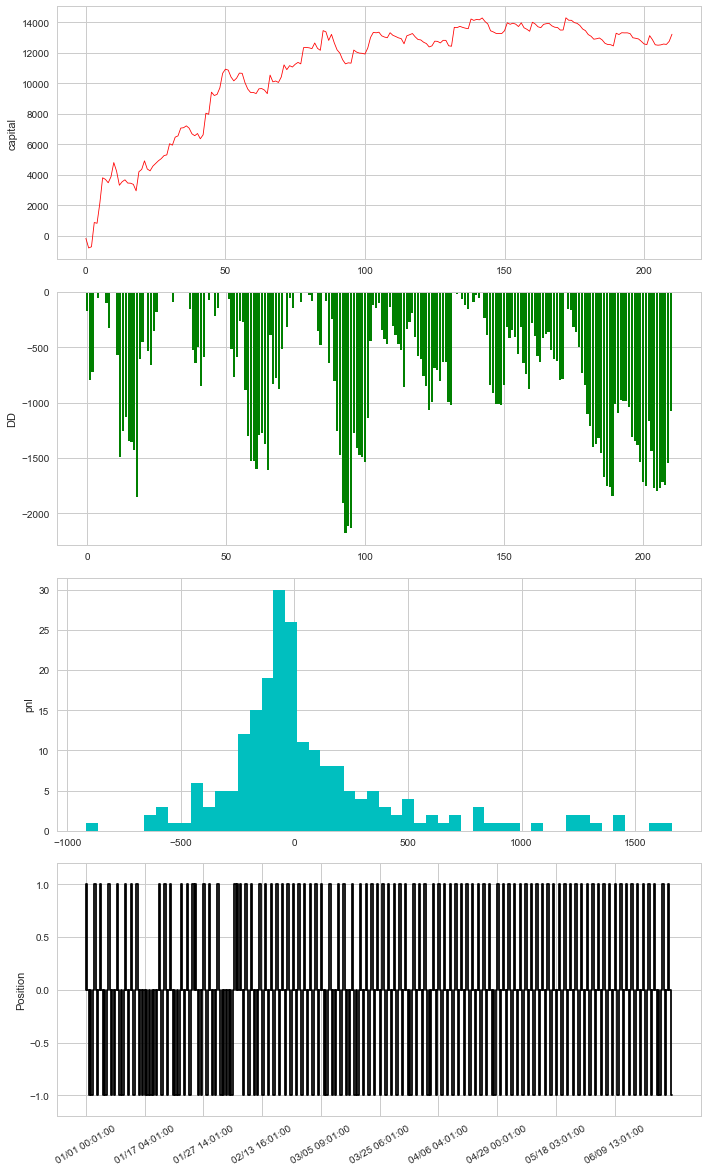

In [4]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

In [5]:
df = engine.calculateDailyResult()

2018-07-14 14:54:57.980685	计算按日统计结果


In [6]:
df1, result = engine.calculateDailyStatistics(df)

In [7]:
result

{'annualizedReturn': 1.7532299390804578,
 'dailyCommission': 21.22091409908718,
 'dailyNetPnl': 73.05124746168639,
 'dailyReturn': 0.007387803536589458,
 'dailySlippage': 0.46519337016574613,
 'dailyTradeCount': 2.3259668508287294,
 'dailyTurnover': 21220.91409908719,
 'endBalance': 1013222.2757905652,
 'endDate': datetime.date(2018, 6, 30),
 'lossDays': 89,
 'maxDdPercent': -0.2137939761525928,
 'maxDrawdown': -2169.118938454194,
 'profitDays': 92,
 'returnStd': 0.03907241277566277,
 'sharpeRatio': 2.929211484997973,
 'startDate': datetime.date(2018, 1, 1),
 'totalCommission': 3840.98545193478,
 'totalDays': 181,
 'totalNetPnl': 13222.275790565236,
 'totalReturn': 1.322227579056512,
 'totalSlippage': 84.20000000000005,
 'totalTradeCount': 421,
 'totalTurnover': 3840985.4519347814}